In [10]:
import networkx as nx
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [55]:
import pandas

dff_exp = pandas.read_csv("Differential expression.csv")
mrna_survival = pandas.read_csv("GBM_mrna-survival.csv")


mrna_survival['abs_coeff'] = abs(mrna_survival['Cox_coefficient'])
dff_exp['Gene'] = dff_exp['Gene'].apply(lambda x: x.split('|')[0])

In [12]:

filtered_survival = mrna_survival[mrna_survival['abs_coeff'] > 0.23]

p_cutoff = 0.05

filtered_de = dff_exp[dff_exp['padj'] < p_cutoff]

In [13]:
#down regulated genes
down_df = filtered_de[filtered_de['log2FoldChange'] < -3]
#up regulated genes
up_df = filtered_de[filtered_de['log2FoldChange'] > 2.70]

In [14]:
selected_genes = pd.concat([filtered_survival, down_df, up_df], ignore_index=True)
selected_genes = selected_genes.dropna(subset=['Gene'])

In [15]:
import stringdb

gene_list = selected_genes['Gene']
string_ids = stringdb.get_string_ids(gene_list)

In [16]:
network = stringdb.get_network(string_ids.queryItem)

In [17]:
network = network[network['score'] > 0.72]

In [18]:
interactions = network[['preferredName_A', 'preferredName_B', 'score']]

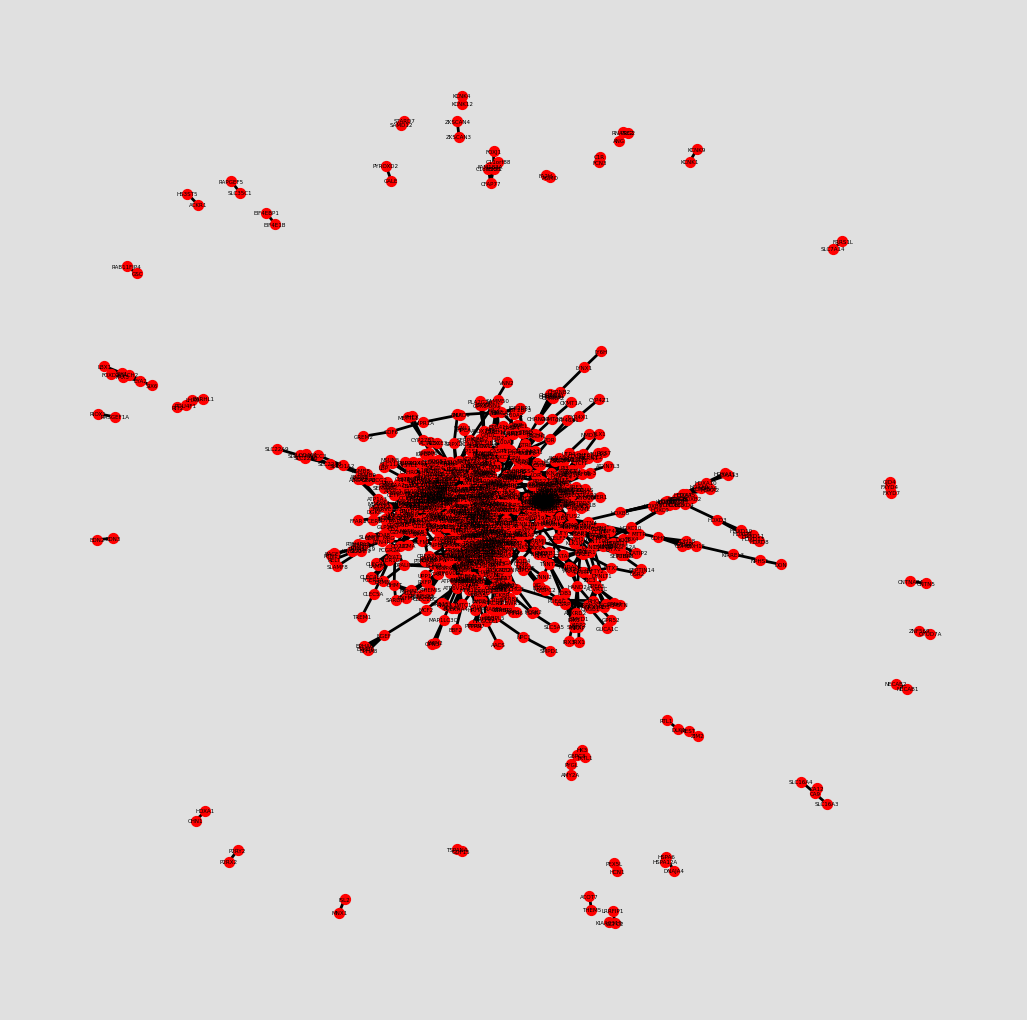

In [57]:
G=nx.Graph(name='PPI Network')
interactions = np.array(interactions)
for i in range(len(interactions)):
    interaction = interactions[i]
    a = interaction[0]
    b = interaction[1]
    w = float(interaction[2])
    G.add_weighted_edges_from([(a,b,w)])

pos = nx.spring_layout(G, k=0.55)
plt.figure(figsize=(13,13),facecolor=[0.7,0.7,0.7,0.4])
nx.draw_networkx(G, width=2, font_size=4, node_size=50, node_color='red')
plt.axis('off')
plt.savefig("first_net.png")
plt.show()

In [23]:
high_exp_genes = filtered_de[filtered_de['baseMean'] > 2980]
selected_genes2 = pd.concat([filtered_survival, high_exp_genes], ignore_index=True)
selected_genes2 = selected_genes2.dropna(subset=['Gene'])

In [24]:
selected_genes2 = selected_genes2.dropna(subset=['Gene'])

In [25]:
gene_list2 = selected_genes2['Gene']
string_ids2 = stringdb.get_string_ids(gene_list2)

In [27]:
network2 = stringdb.get_network(string_ids2.queryItem)
network2.score.sort_values()

66615    0.400
18490    0.400
18491    0.400
952      0.400
953      0.400
         ...  
68636    0.999
23743    0.999
68649    0.999
68648    0.999
23742    0.999
Name: score, Length: 68676, dtype: float64

In [28]:
network2 = network2[network2['score'] > 0.7]

In [29]:
interactions2 = network2[['preferredName_A', 'preferredName_B', 'score']]

In [ ]:
G2=nx.Graph(name='PPI Network')
interactions2 = np.array(interactions2)
for i in range(len(interactions2)):
    interaction = interactions2[i]
    a = interaction[0]
    b = interaction[1]
    w = float(interaction[2])
    G2.add_weighted_edges_from([(a,b,w)])

pos = nx.spring_layout(G2, k=0.55)
plt.figure(figsize=(11,11),facecolor=[0.7,0.7,0.7,0.4])
nx.draw_networkx(G, width=2, font_size=4, node_size=50, node_color='green')
plt.axis('off')
plt.savefig("sec_net.png")
plt.show()

In [32]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)


centrality = pd.DataFrame({
    'degree': degree_centrality,
    'betweenness': betweenness_centrality,
    'eigenvector': eigenvector_centrality
})

centrality['combined'] = centrality.mean(axis=1)
top40_first = centrality.sort_values('combined', ascending=False).head(40)

In [34]:
degree_centrality2 = nx.degree_centrality(G2)
betweenness_centrality2 = nx.betweenness_centrality(G2)
eigenvector_centrality2 = nx.eigenvector_centrality(G2)

centrality2 = pd.DataFrame({
    'degree': degree_centrality2,
    'betweenness': betweenness_centrality2,
    'eigenvector': eigenvector_centrality2
})

centrality2['combined'] = centrality2.mean(axis=1)

top40_second = centrality2.sort_values('combined', ascending=False).head(40)

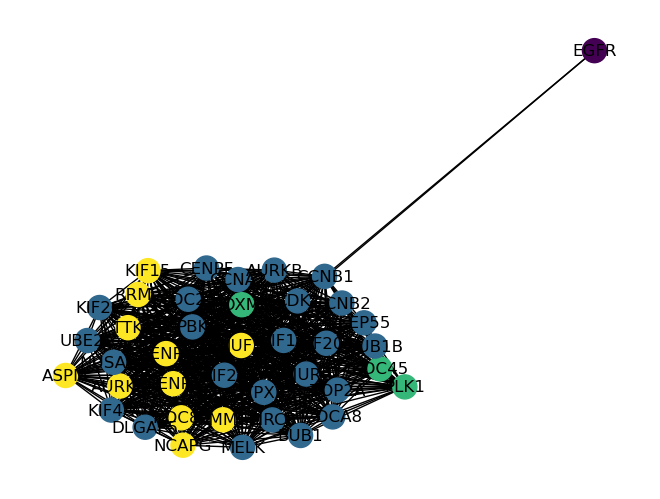

In [37]:
from sklearn.cluster import KMeans

central_nodes = list(top40_first.index)
G_central = G.subgraph(central_nodes)
# Generate centrality scores
degree_centrality = nx.degree_centrality(G_central)
betweenness_centrality = nx.betweenness_centrality(G_central)

# Create DataFrame with centralities
node_centralities = pd.DataFrame({
    'degree': degree_centrality,
    'betweenness': betweenness_centrality,

})

model = KMeans(n_clusters=4)
model.fit(node_centralities)

labels = model.labels_
for i, node in enumerate(G_central.nodes()):
    G_central.nodes[node]['cluster'] = labels[i]
    
G_central = G.subgraph(central_nodes)
pos = nx.spring_layout(G_central)  
nx.draw(G_central, pos=pos, 
        node_color=list(nx.get_node_attributes(G_central,'cluster').values()),
        with_labels=True)

In [38]:
node_centralities['combined'] = node_centralities.mean(axis=1)

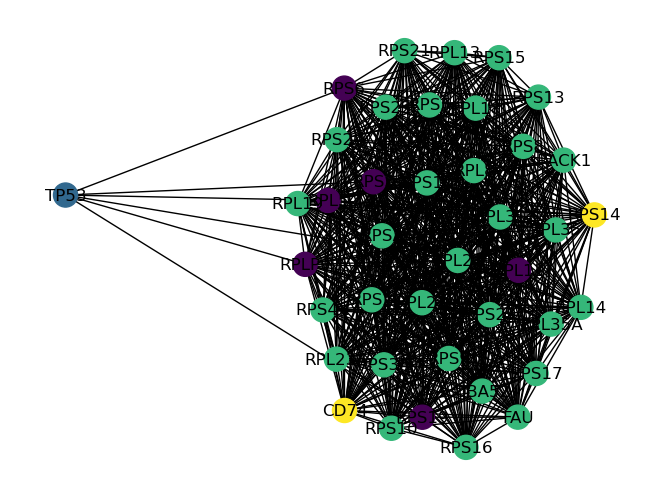

In [54]:
from sklearn.cluster import KMeans

central_nodes2 = list(top40_second.index)
G_central2 = G2.subgraph(central_nodes2)
# Generate centrality scores
degree_centrality2 = nx.degree_centrality(G_central2)
betweenness_centrality2 = nx.betweenness_centrality(G_central2)

# Create DataFrame with centralities
node_centralities2 = pd.DataFrame({
    'degree': degree_centrality2,
    'betweenness': betweenness_centrality2,

})

model = KMeans(n_clusters=4)
model.fit(node_centralities2)

labels2 = model.labels_

for i, node in enumerate(G_central2.nodes()):
    G_central2.nodes[node]['cluster'] = labels2[i]
    

pos = nx.spring_layout(G_central2)  
nx.draw(G_central2, pos=pos, 
        node_color=list(nx.get_node_attributes(G_central2,'cluster').values()),
        with_labels=True)

In [40]:
node_centralities2['combined'] = node_centralities2.mean(axis=1)

In [41]:
centrality_clusters = nx.get_node_attributes(G_central, 'cluster')

In [42]:
selected_centrals = []
for i in range(4):
    cluster = i

    nodes = [n for n in centrality_clusters if centrality_clusters[n]==cluster]
    ranked_nodes = sorted(nodes, key=lambda x: node_centralities.loc[x,'combined'], reverse=True)
    top_node = ranked_nodes[0]
    selected_centrals.append(top_node)

In [53]:
selected_centrals

['EGFR', 'CLTB', 'FOXM1', 'EYA1']

In [44]:
centrality_clusters2 = nx.get_node_attributes(G_central2, 'cluster')
selected_centrals2 = []
for i in range(4):
    cluster = i
    
    nodes = [n for n in centrality_clusters2 if centrality_clusters2[n]==cluster] 
    ranked_nodes = sorted(nodes, key=lambda x: node_centralities2.loc[x,'combined'], reverse=True)
    top_node = ranked_nodes[0]
    selected_centrals2.append(top_node)

In [48]:
selected_centrals2

['RPS8', 'TP53', 'RPS3', 'RPS14']

**If we examine the central nodes identified in each network, the following are the Cox regression coefficients for those genes from the survival analysis:**


first Network's centralities:

1.CDK1: 0.00274

2.CLTB: 0.2139

3.FOXM1: 0.11

4.EYA1: 0.2102




second Network's centralities:

1.RPS3A: -0.129

2.TP53: -0.2007

3.RPL5: -0.1552

4.CD74: 0.1117